In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import polars as pl
import numpy as np

In [8]:
edges = pl.read_csv("edgelists1.csv") #loading data
nodes = pl.read_csv("node_info1.csv")
print(edges)

id_list = edges['id'].unique(maintain_order=True).to_list() #keeps the main order
#id_list = sorted(edges['id'].unique().to_list()) #alphabetical sort 
print(id_list)

all_deg = []


def makegraph(a): 
    edges_group = edges.filter(pl.col('id') == a)
    G = nx.from_pandas_edgelist(edges_group, source = 'from', target = 'to') #Get the information from the tables df with node being from, target being to, and edges from connectivity (which one the node is connected to)
    #nx.draw(G, node_color = 'blue', node_size = 10, edgecolors='black', alpha = 0.7) #This draws the graph with specified node color, size, edge color and transparency
    #plt.title(a)  # add a title for each graph
    #plt.show()
    degrees = [d for n, d in G.degree()] #for each node in the node/degree dict, takes just the degrees into a list
    less2 = [d for d in degrees if d < 2]
    p = len(less2)/len(degrees)
    r = 2
    md = np.mean(degrees)
    vd = np.var(degrees)
    return md, vd

mean_degree = []
var_degree = []
for idx in id_list:
    md, vd = makegraph(idx)
    mean_degree.append(md.item())
    var_degree.append(vd.item())
#for i in id_list: #there's 382 networks so idk how we can make all of them and display 
#    makegraph(i)






shape: (3_259, 3)
┌─────────────────────┬──────┬─────┐
│ id                  ┆ from ┆ to  │
│ ---                 ┆ ---  ┆ --- │
│ str                 ┆ str  ┆ str │
╞═════════════════════╪══════╪═════╡
│ aus.2000.meas.1.00  ┆ P1   ┆ P2  │
│ aus.2000.meas.1.00  ┆ P1   ┆ P3  │
│ aus.2000.meas.1.00  ┆ P3   ┆ P4  │
│ aus.2000.meas.1.00  ┆ P3   ┆ P5  │
│ aus.2003.meas.1.00  ┆ P1   ┆ P2  │
│ …                   ┆ …    ┆ …   │
│ rou.2020.covid.1.16 ┆ P1   ┆ P2  │
│ rou.2020.covid.1.17 ┆ P1   ┆ P2  │
│ rou.2020.covid.1.18 ┆ P1   ┆ P2  │
│ rou.2020.covid.1.19 ┆ P1   ┆ P2  │
│ rou.2020.covid.1.20 ┆ P1   ┆ P2  │
└─────────────────────┴──────┴─────┘
['aus.2000.meas.1.00', 'aus.2003.meas.1.00', 'aus.2010.meas.1.00', 'bgd.2001.nph.1.01', 'bgd.2001.nph.1.02', 'bgd.2001.nph.1.03', 'bgd.2001.nph.1.04', 'bgd.2001.nph.1.05', 'bgd.2001.nph.1.06', 'bgd.2001.nph.1.07', 'bgd.2001.nph.1.08', 'bgd.2001.nph.1.11', 'bgd.2001.nph.1.12', 'bgd.2001.nph.1.13', 'bgd.2001.nph.1.14', 'bgd.2001.nph.1.15', 'bgd.2001.nph

C:\Users\benwu\AppData\Local\Temp\ipykernel_21268\1870107128.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


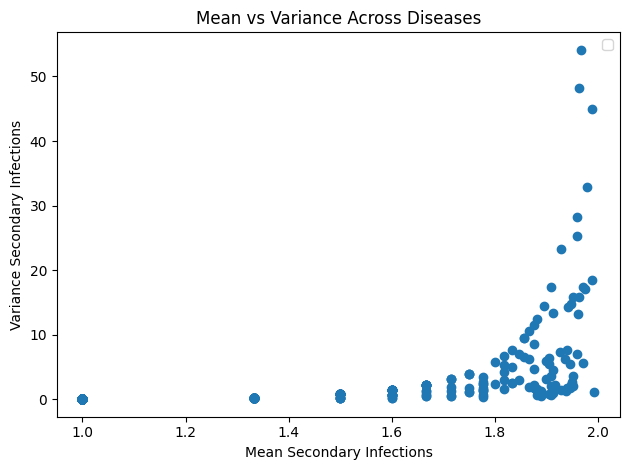

In [9]:
plt.scatter(mean_degree, var_degree)
plt.xlabel("Mean Secondary Infections")
plt.ylabel("Variance Secondary Infections")
plt.title("Mean vs Variance Across Diseases")
plt.legend()
plt.tight_layout()
plt.show()

Loads two CSVs (edgelists1.csv, node_info1.csv) and builds one combined graph over all outbreaks.

(Recommended) Uses composite node IDs like "{id}:{name}" so identical names (e.g., P1) from different outbreaks don’t collide.

Constructs a directed graph (default) so each node’s out-degree = secondary infections; can switch to undirected with use_out_degree=False.

Extracts the degree vector for all nodes (including zeros).

Fits a Negative Binomial (NB) to the empirical degree distribution 


Plots a histogram of degrees (0–30) and overlays the NB PMF using the fitted parameters.

Labels axes/legend and shows the sample mean and variance in the title.

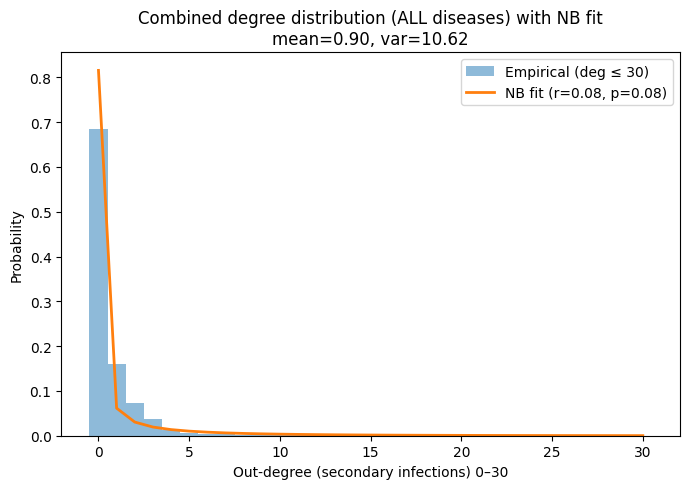

In [10]:
# Plot degree histogram with Negative Binomial (NB) fit — ALL DISEASES COMBINED

import polars as pl
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom

EDGES_CSV = "edgelists1.csv"
NODES_CSV = "node_info1.csv"

# --- Helper: method-of-moments NB fit on {0,1,2,...} ---
def fit_nb_mom(deg: np.ndarray):
 
    if deg.size == 0:
        raise ValueError("Empty degree array.")
    m = deg.mean()
    s2 = deg.var(ddof=1) if deg.size > 1 else 0.0
    if m > 0 and s2 > m:
        r_hat = (m**2) / (s2 - m)
        p_hat = r_hat / (r_hat + m)
    else:
        r_hat = 1e9
        p_hat = r_hat / (r_hat + m) if m > 0 else 0.999999999
    return r_hat, p_hat, m, s2

def main(use_out_degree: bool = True, max_plot: int = 30):
    # Load data
    edges_df = pl.read_csv(EDGES_CSV)
    nodes_df = pl.read_csv(NODES_CSV)

    # Build edge list and node list with the correct columns
    # (your files use 'from','to' for edges and 'name' for node IDs)
    edge_pairs = [(f"{i}:{u}", f"{i}:{v}") for i, u, v in edges_df.select(["id", "from", "to"]).rows()]
    node_names = [f"{i}:{n}" for i, n in nodes_df.select(["id", "name"]).rows()]

    # Graph across ALL diseases (combined)
    if use_out_degree:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    G.add_nodes_from(node_names)
    G.add_edges_from(edge_pairs)

    # Degree vector (include nodes with zero degree)
    if use_out_degree and isinstance(G, nx.DiGraph):
        deg = np.array([d for _, d in G.out_degree(node_names)], dtype=float)
        x_label = f"Out-degree (secondary infections) 0–{max_plot}"
    else:
        deg = np.array([d for _, d in G.degree(node_names)], dtype=float)
        x_label = f"Degree 0–{max_plot}"

    if deg.size == 0:
        raise ValueError("Degree sequence is empty after graph construction.")

    # Fit NB
    r_hat, p_hat, m, s2 = fit_nb_mom(deg)

    # Histogram + NB PMF overlay
    deg_int = deg.astype(int)
    xmax = int(deg_int.max())
    x = np.arange(0, min(xmax, max_plot) + 1)
    pmf_nb = nbinom.pmf(x, r_hat, p_hat, loc=0)

    plt.figure(figsize=(7, 5))
    plt.hist(
        deg_int[deg_int <= max_plot],
        bins=np.arange(-0.5, max_plot + 1.5, 1),
        density=True, alpha=0.5, label=f"Empirical (deg ≤ {max_plot})"
    )
    plt.plot(x, pmf_nb, lw=2, label=f"NB fit (r={r_hat:.2f}, p={p_hat:.2f})")
    plt.xlabel(x_label)
    plt.ylabel("Probability")
    plt.title(f"Combined degree distribution (ALL diseases) with NB fit\nmean={m:.2f}, var={s2:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # use_out_degree=True → transmission (secondary infections); False → undirected contact degree
    main(use_out_degree=True, max_plot=30)



=== chn.2003.sars.1.00 ===
Cases: 79
Mean (R proxy): 0.9873
Variance:       18.1152
k (dispersion): 0.0569156
p:              0.054503


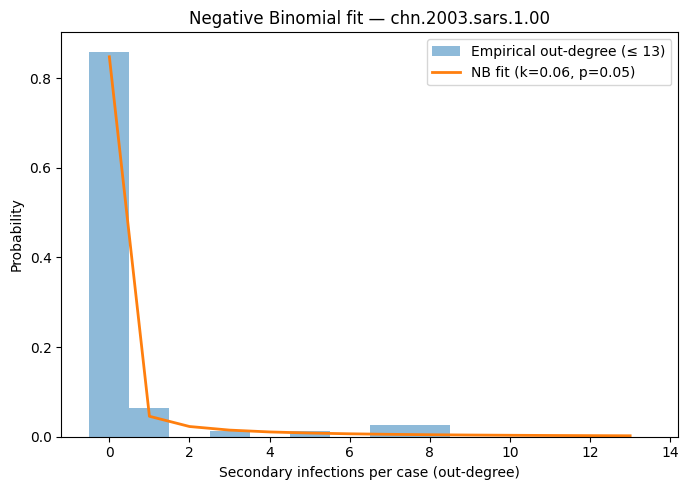


=== kor.2015.mers.1.00 ===
Cases: 186
Mean (R proxy): 0.9946
Variance:       45.5189
k (dispersion): 0.0222188
p:              0.021851


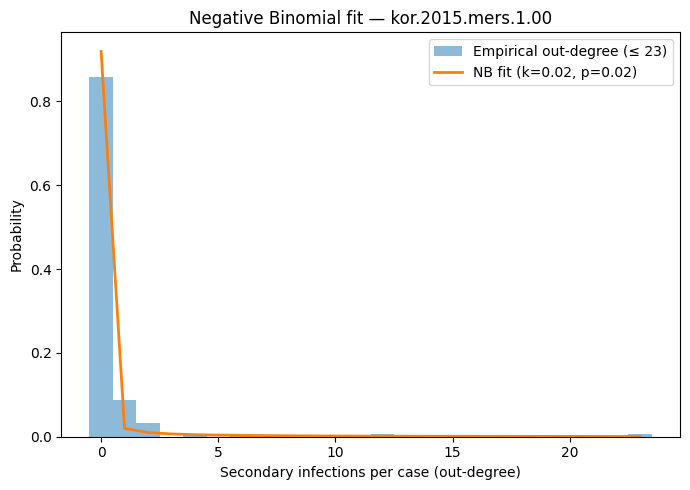


=== chn.2020.covid.1.00 ===
Cases: 20
Mean (R proxy): 0.9500
Variance:       3.6289
k (dispersion): 0.336886
p:              0.261784


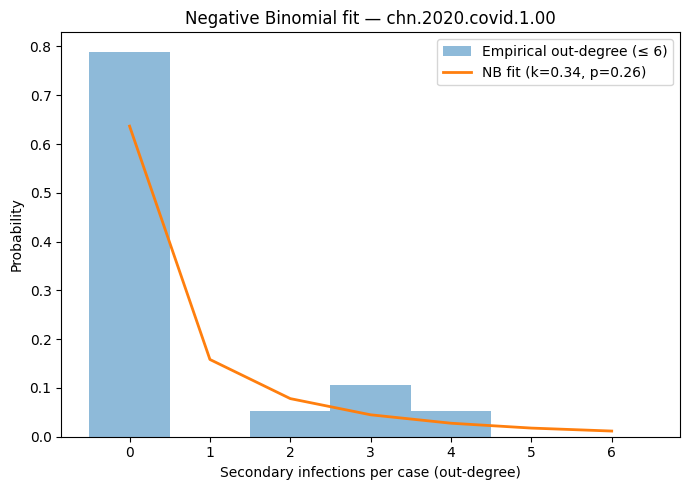

In [11]:
import polars as pl
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom  

# Path to edge list CSV. Expected columns: id, from, to
EDGES_PATH = "edgelists1.csv"

# Outbreak IDs 
TARGET_DISEASES = ["chn.2003.sars.1.00", "kor.2015.mers.1.00", "chn.2020.covid.1.00"]

# Load edges (id, from, to) 
edges_df = pl.read_csv(EDGES_PATH)  # columns: id, from, to

# Build a namespaced directed graph:
#   - Use DiGraph so out-degree = number of secondary infections
#   - Prefix each node with its outbreak id (e.g., "chn.2003.sars.1.00:P1")
G = nx.DiGraph()
for rid, u, v in edges_df.select(["id", "from", "to"]).rows():
    u_ns = f"{rid}:{u}"  # namespaced source node
    v_ns = f"{rid}:{v}"  # namespaced target node
    G.add_edge(u_ns, v_ns)

# Method-of-moments Negative Binomial 
# Returns:
#   mean (sample mean), var (sample variance, ddof=1),
#   k (dispersion / "size" parameter in NB), p (success probability in SciPy's nbinom)
# Notes:
#   - If variance <= mean, data are not overdispersed; we approximate a Poisson by k → large.
def fit_nb_mom(sample):
    x = np.asarray(sample, dtype=float)
    if x.size == 0:
        return dict(mean=0.0, var=0.0, k=np.inf, p=1.0)
    m = x.mean()
    s2 = x.var(ddof=1) if x.size > 1 else 0.0
    if m <= 0:
        # No infections on average; NB undefined ⇒ return Poisson-like limit
        return dict(mean=m, var=s2, k=np.inf, p=1.0)
    if s2 > m:
        # Overdispersed: solve method-of-moments for NB parameters
        #   Var = m + m^2/k  ⇒  k = m^2 / (Var - m)
        #   mean = r(1-p)/p with r=k  ⇒  p = k/(k+m)
        k = (m**2) / (s2 - m)
        p = k / (k + m)
    else:
        # Not overdispersed (Poisson-like): emulate Poisson by taking k very large
        k = 1e12
        p = k / (k + m)
    return dict(mean=m, var=s2, k=k, p=p)

# Fit NB and plot the histogram + NB PMF for each outbreak separately
for outbreak in TARGET_DISEASES:
    # Collect nodes that belong to this outbreak by namespaced prefix
    nodes_d = [n for n in G.nodes if n.startswith(outbreak + ":")]
    if not nodes_d:
        print(f"[WARN] No nodes found for {outbreak}. Check the id string.")
        continue

    # Induced subgraph for the outbreak
    H = G.subgraph(nodes_d).copy()

    # Secondary infections per case = out-degree in the directed graph
    deg_out = np.array([H.out_degree(n) for n in nodes_d], dtype=int)

    # Fit Negative Binomial via MoM
    fit = fit_nb_mom(deg_out)

    # Console summary
    print(f"\n=== {outbreak} ===")
    print(f"Cases: {len(deg_out)}")
    print(f"Mean (R proxy): {fit['mean']:.4f}")
    print(f"Variance:       {fit['var']:.4f}")
    print(f"k (dispersion): {fit['k']:.6g}")
    print(f"p:              {fit['p']:.6f}")

    # Plot: empirical histogram of out-degree and the fitted NB PMF over 0..xmax_plot
    if len(deg_out) > 0:
        # Choose a readable x-maximum (99th percentile, capped at 40)
        xmax_plot = min(int(np.percentile(deg_out, 99)), 40)
        x = np.arange(0, xmax_plot + 1)

        # SciPy NB parameterization: nbinom.pmf(k; r=k, p=p) on {0,1,2,...}
        pmf_nb = nbinom.pmf(x, fit["k"], fit["p"], loc=0)

        plt.figure(figsize=(7, 5))
        plt.hist(
            deg_out[deg_out <= xmax_plot],
            bins=np.arange(-0.5, xmax_plot + 1.5, 1),
            density=True, alpha=0.5,
            label=f"Empirical out-degree (≤ {xmax_plot})"
        )
        plt.plot(x, pmf_nb, lw=2, label=f"NB fit (k={fit['k']:.2f}, p={fit['p']:.2f})")
        plt.xlabel("Secondary infections per case (out-degree)")
        plt.ylabel("Probability")
        plt.title(f"Negative Binomial fit — {outbreak}")
        plt.legend()
        plt.tight_layout()
        plt.show()


For each target outbreak ID:

Compute secondary infections per node = how many people each case infected (out-degree).

Plot a scatter of those per-node counts (one figure per disease).

Compute the mean and variance of those counts.

After looping through all diseases, plot a combined scatter of mean vs. variance (one point per disease).

Save a CSV summary (secondary_infection_stats.csv) with the metrics.

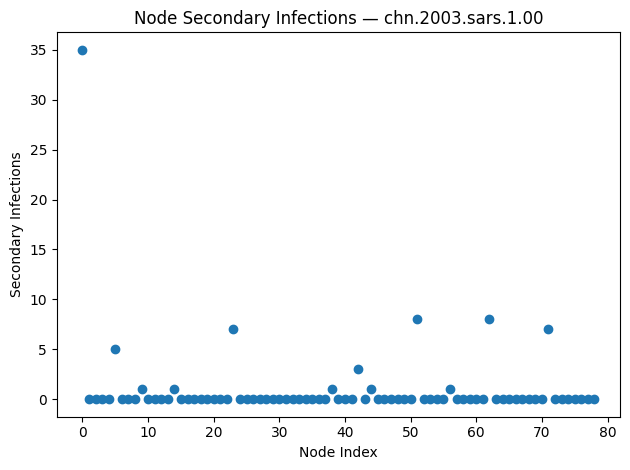

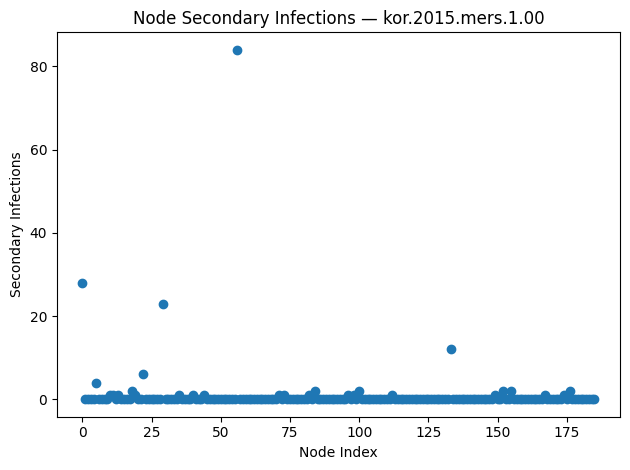

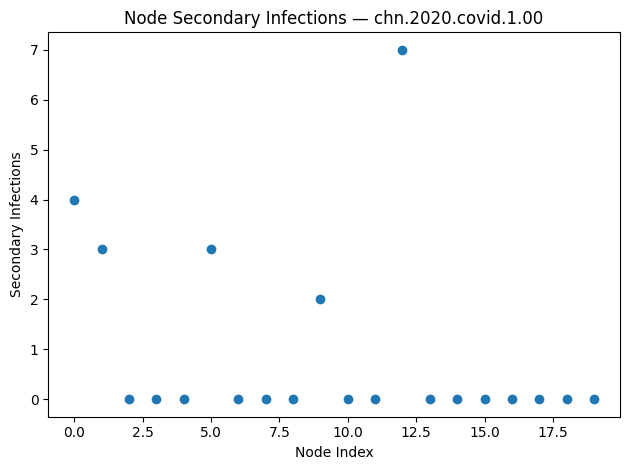

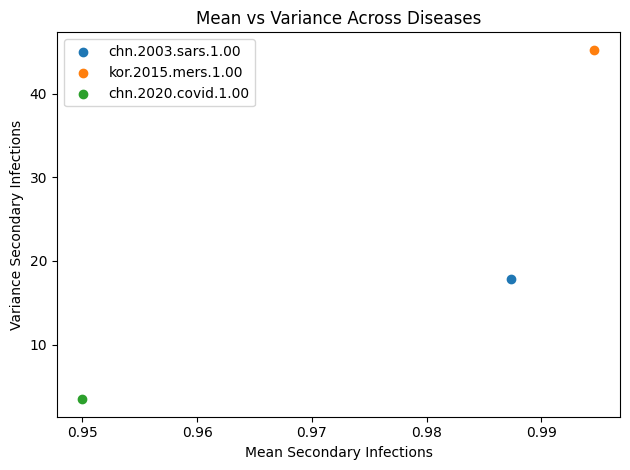

Saved summary to C:\Users\benwu\OneDrive - University of Virginia\BIOL4559HW\secondary_infection_stats.csv


In [12]:


import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

EDGES_CSV = "edgelists1.csv"
NODES_CSV = "node_info1.csv"
TARGET_DISEASES = ["chn.2003.sars.1.00", "kor.2015.mers.1.00", "chn.2020.covid.1.00"]

def per_disease_secondary_counts(edges: pl.DataFrame, nodes: pl.DataFrame, disease_id: str) -> pl.DataFrame:
    e = edges.filter(pl.col("id") == disease_id)
    n = nodes.filter(pl.col("id") == disease_id).select("name")

    # out-degree = number of times a case appears as `from` in the edge list
    out_counts = (
        e.group_by("from")
         .len()
         .rename({"from": "name", "len": "secondary_infections"})
    )

    # join to ensure nodes with no onward infections show as 0
    per_node = (
        n.join(out_counts, on="name", how="left")
         .with_columns(pl.col("secondary_infections").fill_null(0))
         .with_columns(pl.col("secondary_infections").cast(pl.Float64))
    )
    return per_node

def plot_node_scatter(per_node: pl.DataFrame, disease_id: str) -> None:
    y = per_node["secondary_infections"].to_numpy()
    x = np.arange(len(y))
    plt.figure()
    plt.scatter(x, y, marker="o")
    plt.xlabel("Node Index")
    plt.ylabel("Secondary Infections")
    plt.title(f"Node Secondary Infections — {disease_id}")
    plt.tight_layout()
    plt.show()

def main():
    edges = pl.read_csv(EDGES_CSV)
    nodes = pl.read_csv(NODES_CSV)

    results = []  # store (disease, mean, variance, n_nodes, n_edges)

    for disease in TARGET_DISEASES:
        per_node = per_disease_secondary_counts(edges, nodes, disease)
        counts = per_node["secondary_infections"].to_numpy()
        mean_val = float(np.mean(counts))
        var_val = float(np.var(counts, ddof=0))  # population variance

        # node-level scatter
        plot_node_scatter(per_node, disease)

        # collect summary
        n_edges = int(edges.filter(pl.col("id") == disease).height)
        results.append({
            "disease": disease,
            "mean_secondary_infections": mean_val,
            "variance_secondary_infections": var_val,
            "n_nodes": int(per_node.height),
            "n_edges": n_edges,
        })

    # mean-vs-variance combined scatter
    plt.figure()
    for r in results:
        plt.scatter(r["mean_secondary_infections"], r["variance_secondary_infections"], label=r["disease"], marker="o")
    plt.xlabel("Mean Secondary Infections")
    plt.ylabel("Variance Secondary Infections")
    plt.title("Mean vs Variance Across Diseases")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # save summary CSV
    out = pl.DataFrame(results)
    out_path = Path("secondary_infection_stats.csv")
    out.write_csv(out_path)
    print(f"Saved summary to {out_path.resolve()}")

if __name__ == "__main__":
    main()


⚠️ No command-line arguments detected — using default parameters.
R0= 2.0, run = 0, pop = 10.
R0= 2.0, run = 0, pop = 100.
R0= 2.0, run = 0, pop = 1000.
R0= 2.0, run = 0, pop = 1000000.
R0= 2.0, run = 0, pop = 10.
R0= 2.0, run = 0, pop = 100.
R0= 2.0, run = 0, pop = 1000.
R0= 2.0, run = 0, pop = 1000000.


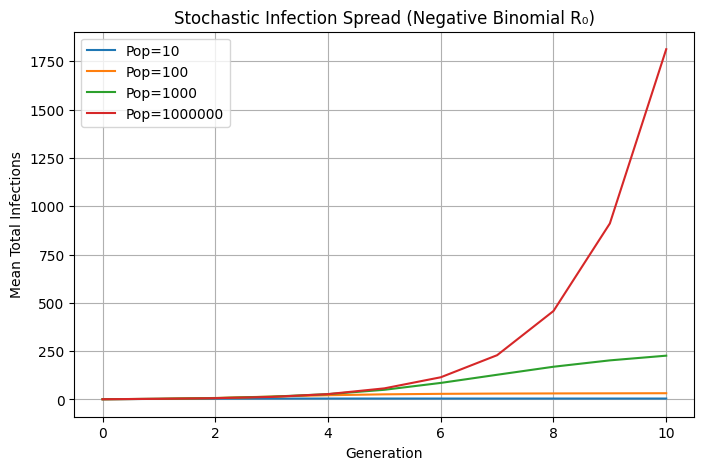

In [13]:
# ----------------------------------------------
# IMPORTS
# ----------------------------------------------

import numpy.random as ran   # for random number generation (Poisson, NegBin, Hypergeometric)
import numpy as np           # general numerical tools
import pandas as pd          # data handling and saving results to CSV
import argparse              # for command-line arguments (optional)
import sys                   # system-specific parameters and arguments

# ----------------------------------------------
# FUNCTION DEFINITIONS
# ----------------------------------------------

# Random draw of new infections based on susceptible pool
def random_draw(n_draw, susceptible, total_population):
    # Draws the number of susceptible individuals infected
    # using a hypergeometric distribution
    draw_susceptible = ran.hypergeometric(
        susceptible,                   # number of susceptible individuals
        total_population - susceptible, # number of non-susceptible individuals
        n_draw                          # number of infection attempts (draws)
    )
    return draw_susceptible

# Draw R₀ (reproductive number) from a negative binomial distribution
def get_R0_negbiom(R0_mean, max_R0, k_overdispersion):
    # If k not provided, stop the simulation
    if k_overdispersion is None:
        print("error: k overdispersion parameter not specified.")
        exit(1)

    # Calculate success probability p for negative binomial distribution
    p = 1.0 - R0_mean / (R0_mean + k_overdispersion)

    # Draw a random R₀ value
    result = ran.negative_binomial(k_overdispersion, p)

    # Ensure the drawn R₀ does not exceed max_R0
    if max_R0 > 0:
        while result > max_R0:
            result = ran.negative_binomial(k_overdispersion, p)

    return result

# Draw R₀ from a Poisson distribution
def get_R0_poisson(R0_mean, max_R0):
    # Draw a random R₀ value
    result = ran.poisson(R0_mean)

    # Ensure R₀ does not exceed max_R0
    if max_R0 > 0:
        while result > max_R0:
            result = ran.poisson(R0_mean)
    return result

# -----------------------------------------------------
# MAIN SIMULATION FUNCTION
# -----------------------------------------------------
def run_simulation(total_runs, max_generation, R0_dist_type, mean_R0, k_overdispersion):
    # -------------------------------------------------
    # DETERMINISTIC SIMULATION (no randomness)
    # -------------------------------------------------
    report_colnames = ['generation', 'infected']  # column names
    report_deterministic = pd.DataFrame(columns=report_colnames)

    # For each generation, compute number of infections deterministically
    for generation in range(1, max_generation + 1):
        report_deterministic.loc[len(report_deterministic)] = [
            generation, 
            pow(mean_R0, generation)  # infections grow exponentially
        ]

    # Save deterministic results to CSV
    report_deterministic.to_csv(f'infection_deterministic_R0_{mean_R0}.csv', index=False)

    # -------------------------------------------------
    # STOCHASTIC SIMULATION (with randomness)
    # -------------------------------------------------
    population_sizes = [10, 100, 1000, 1000000]  # simulate for several population sizes

    # Loop through each population size
    for population_size in population_sizes:
        mean_R0 = round(mean_R0, 1)
        report_colnames = ['run', 'generation', 'new_infected', 'total_infected']
        report = pd.DataFrame(columns=report_colnames)
        max_R0 = population_size  # set an upper bound for R₀

        # Repeat simulation multiple times for averaging
        for run in range(total_runs):
            # Print progress every 100 runs
            if run % 100 == 0:
                print(f"R0= {mean_R0}, run = {run}, pop = {population_size}.")

            # Initial conditions
            generation = 0
            number_active_infections = 1  # start with 1 infected individual
            cumu_infections = number_active_infections
            susceptible = population_size - number_active_infections

            # Record initial state
            report.loc[len(report)] = [run, generation, number_active_infections, cumu_infections]

            # Loop through each generation of infection spread
            while generation < max_generation:
                generation += 1
                new_active_infections = 0  # reset new infections for this generation

                # For each active infection, draw how many new infections occur
                for infection in range(number_active_infections):
                    # Choose the distribution of R₀ based on user input
                    if R0_dist_type == "negative_binomial":
                        R0_draw = get_R0_negbiom(mean_R0, max_R0, k_overdispersion)
                    elif R0_dist_type == "poisson":
                        R0_draw = get_R0_poisson(mean_R0, max_R0)
                    else:
                        print("error: unknown distribution of R0.")
                        exit(1)

                    # If the R₀ value is positive, infect that many susceptibles
                    if R0_draw > 0:
                        number_newinfection = random_draw(R0_draw, susceptible, population_size)
                        new_active_infections += number_newinfection
                        susceptible -= number_newinfection
                    elif R0_draw < 0:
                        # Should never happen, but handle gracefully
                        print("error: negative R0 draw.")
                        exit(1)

                # Update counts for next generation
                number_active_infections = new_active_infections
                cumu_infections += new_active_infections

                # Save results for this generation
                report.loc[len(report)] = [run, generation, number_active_infections, cumu_infections]

        # Save all results for this population size
        report.to_csv(f'infection_{R0_dist_type}_pop_{population_size}_R0_{mean_R0}.csv', index=False)

# -----------------------------------------------------
# ARGUMENT PARSING (for command line or Jupyter use)
# -----------------------------------------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-r", "--run_total", type=int, help="total number of runs")
    parser.add_argument("-g", "--max_generation", type=int, help="max number of generations")
    parser.add_argument("-d", "--dist_type", help="distribution type of secondary cases")
    parser.add_argument("-m", "--mean", type=float, help="mean value of secondary cases")
    parser.add_argument("-k", "--k_overdispersion", type=float, help="overdispersion parameter (k)")

    # parse_known_args() ignores extra arguments from Jupyter (like --f=kernel.json)
    args, unknown = parser.parse_known_args()

    # If no command-line arguments, use defaults
    if len(sys.argv) == 1 or any("ipykernel" in a for a in sys.argv):
        print("⚠️ No command-line arguments detected — using default parameters.")
        args.run_total = 100
        args.max_generation = 10
        args.dist_type = "poisson"
        args.mean = 2.0
        args.k_overdispersion = None

    # Run the simulation with chosen parameters
    run_simulation(
        total_runs=args.run_total,
        max_generation=args.max_generation,
        R0_dist_type=args.dist_type,
        mean_R0=args.mean,
        k_overdispersion=args.k_overdispersion
    )

# -----------------------------------------------------
# MANUAL OVERRIDE (force negative binomial run in Jupyter)
# -----------------------------------------------------
# Here we manually set parameters to simulate the negative binomial distribution
args.run_total = 100
args.max_generation = 10
args.dist_type = "negative_binomial"
args.mean = 2.0
args.k_overdispersion = 0.5  # smaller k = higher variability between infections

# Run simulation again with negative binomial parameters
run_simulation(
    total_runs=args.run_total,
    max_generation=args.max_generation,
    R0_dist_type=args.dist_type,
    mean_R0=args.mean,
    k_overdispersion=args.k_overdispersion
)

# -----------------------------------------------------
# PLOTTING RESULTS
# -----------------------------------------------------
import matplotlib.pyplot as plt  # for visualization

# Choose which population sizes to include in plot
populations = [10, 100, 1000, 1000000]
R0 = 2.0  # mean R₀ used in simulation

plt.figure(figsize=(8, 5))  # set plot size

for pop in populations:
    # Load simulation results from CSV
    df = pd.read_csv(f"infection_negative_binomial_pop_{pop}_R0_{R0}.csv")
    # Compute mean total infections per generation across all runs
    mean_infections = df.groupby("generation")["total_infected"].mean()
    # Plot infection curve for this population
    plt.plot(mean_infections.index, mean_infections.values, label=f"Pop={pop}")

# Label the plot
plt.xlabel("Generation")
plt.ylabel("Mean Total Infections")
plt.title("Stochastic Infection Spread (Negative Binomial R₀)")
plt.legend()
plt.grid(True)
plt.show()



=== infection_negative_binomial_pop_10_R0_2.0.csv ===
Samples:         1100
Mean infections: 0.4091
Variance:        1.1865
k (dispersion):  0.215287
p:               0.344802


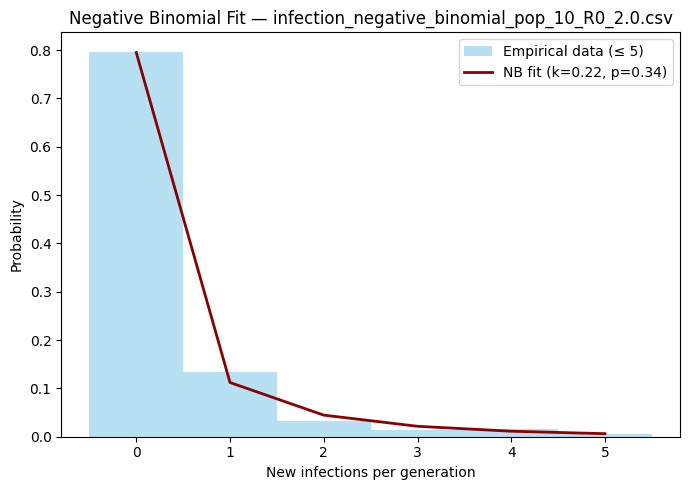


=== infection_negative_binomial_pop_100_R0_2.0.csv ===
Samples:         1100
Mean infections: 2.9182
Variance:        41.5056
k (dispersion):  0.220688
p:               0.070308


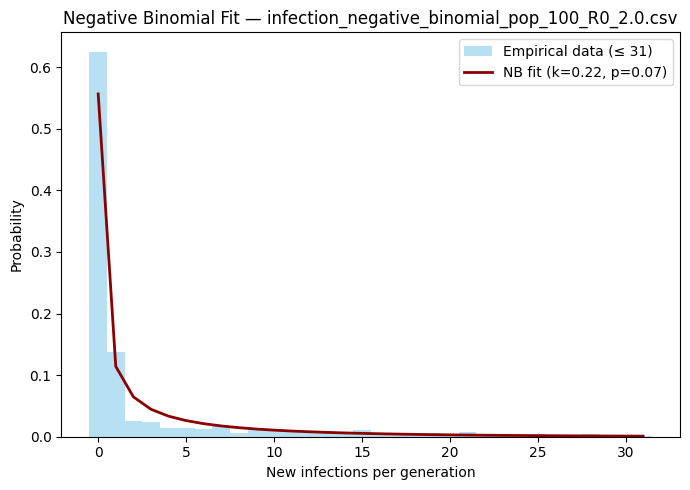


=== infection_negative_binomial_pop_1000_R0_2.0.csv ===
Samples:         1100
Mean infections: 20.5864
Variance:        1950.5904
k (dispersion):  0.219584
p:               0.010554


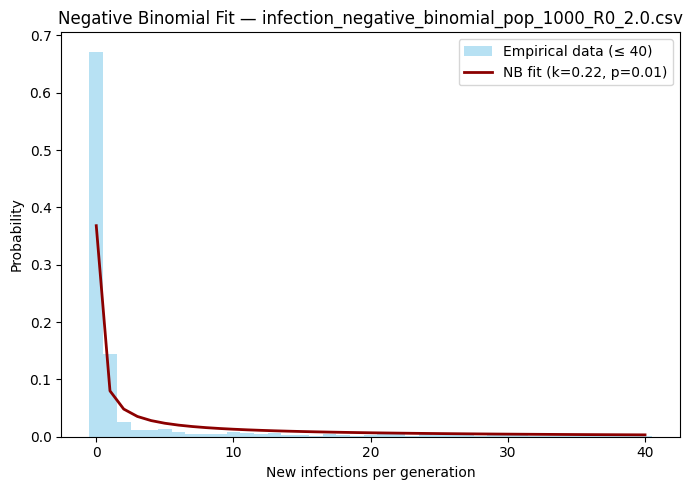


=== infection_negative_binomial_pop_1000000_R0_2.0.csv ===
Samples:         1100
Mean infections: 164.8055
Variance:        520843.3579
k (dispersion):  0.0521643
p:               0.000316


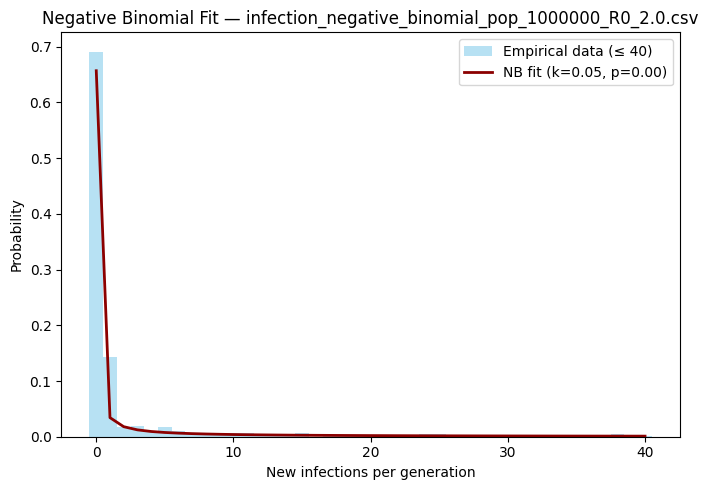

In [14]:
# ============================================
# 📦 IMPORTS
# ============================================
import polars as pl                  # for fast CSV loading and data manipulation
import networkx as nx                # for network graph construction and degree analysis
import numpy as np                   # for numerical operations
import matplotlib.pyplot as plt      # for plotting histograms and fitted PMFs
from scipy.stats import nbinom       # for Negative Binomial probability mass function (PMF)

# ============================================
# 🧬 INPUT FILES — GENERATED MODEL DATA
# ============================================
# Path to your infection simulation CSVs generated earlier.
# These should look like: infection_negative_binomial_pop_100_R0_2.0.csv
# We'll analyze several population sizes to compare variability.
CSV_PATHS = [
    "infection_negative_binomial_pop_10_R0_2.0.csv",
    "infection_negative_binomial_pop_100_R0_2.0.csv",
    "infection_negative_binomial_pop_1000_R0_2.0.csv",
    "infection_negative_binomial_pop_1000000_R0_2.0.csv"
]

# ============================================
# ⚙️ METHOD OF MOMENTS NEGATIVE BINOMIAL FIT
# ============================================
def fit_nb_mom(sample):
    """
    Fits a Negative Binomial (NB) distribution to a given data sample
    using the method of moments.

    Parameters
    ----------
    sample : array-like
        Observed counts (e.g., number of secondary infections per case).

    Returns
    -------
    dict with:
        mean : sample mean
        var  : sample variance
        k    : dispersion parameter (size)
        p    : success probability (in SciPy's nbinom parameterization)
    """
    x = np.asarray(sample, dtype=float)
    if x.size == 0:
        # Handle empty data gracefully
        return dict(mean=0.0, var=0.0, k=np.inf, p=1.0)
    
    m = x.mean()
    s2 = x.var(ddof=1) if x.size > 1 else 0.0  # unbiased sample variance

    if m <= 0:
        # If mean is zero or negative, NB undefined; return Poisson-like limit
        return dict(mean=m, var=s2, k=np.inf, p=1.0)

    if s2 > m:
        # Overdispersed: variance > mean → true Negative Binomial
        # Var = m + m^2/k → solve for k
        k = (m**2) / (s2 - m)
        # mean = r(1-p)/p with r=k → solve for p
        p = k / (k + m)
    else:
        # If variance <= mean, data are approximately Poisson → k → ∞
        k = 1e12
        p = k / (k + m)

    return dict(mean=m, var=s2, k=k, p=p)

# ============================================
# 🔍 ANALYSIS LOOP — ONE PER GENERATED MODEL
# ============================================
for csv_path in CSV_PATHS:
    # --- Load data from your simulation ---
    # Columns: run, generation, new_infected, total_infected
    df = pl.read_csv(csv_path)

    # --- Calculate total new infections per generation across all runs ---
    # This approximates “number of secondary infections” per infection event
    # For simplicity, we’ll treat new_infected counts as independent samples
    new_infections = df["new_infected"].to_numpy()

    # --- Fit the Negative Binomial distribution ---
    fit = fit_nb_mom(new_infections)

    # --- Display summary statistics ---
    print(f"\n=== {csv_path} ===")
    print(f"Samples:         {len(new_infections)}")
    print(f"Mean infections: {fit['mean']:.4f}")
    print(f"Variance:        {fit['var']:.4f}")
    print(f"k (dispersion):  {fit['k']:.6g}")
    print(f"p:               {fit['p']:.6f}")

    # ============================================
    # 📈 Plot histogram vs. fitted NB PMF
    # ============================================
    if len(new_infections) > 0:
        # Choose range for plotting (cap at 40 for clarity)
        xmax_plot = min(int(np.percentile(new_infections, 99)), 40)
        x = np.arange(0, xmax_plot + 1)

        # Compute the NB probability mass function (PMF)
        pmf_nb = nbinom.pmf(x, fit["k"], fit["p"], loc=0)

        # Plot empirical histogram
        plt.figure(figsize=(7, 5))
        plt.hist(
            new_infections[new_infections <= xmax_plot],
            bins=np.arange(-0.5, xmax_plot + 1.5, 1),
            density=True, alpha=0.6, color="skyblue",
            label=f"Empirical data (≤ {xmax_plot})"
        )

        # Overlay fitted NB PMF curve
        plt.plot(x, pmf_nb, lw=2, color="darkred",
                 label=f"NB fit (k={fit['k']:.2f}, p={fit['p']:.2f})")

        # Add titles and labels
        plt.xlabel("New infections per generation")
        plt.ylabel("Probability")
        plt.title(f"Negative Binomial Fit — {csv_path}")
        plt.legend()
        plt.tight_layout()
        plt.show()
